In [1]:
%matplotlib notebook
import os

import cv2
import numpy as np
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
# import tensorflow as tf
from sklearn.neighbors import NearestNeighbors
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import sys
# sys.path.insert(0, '../vae/')
# from VAE import VAE
from tqdm import tnrange, tqdm_notebook

# Clustered classes and their inverse mappings

In [2]:
clustered_classes = []
mapping_classes_index = dict()
clustered_classes_count = []
file_name = 'class_clusters.txt'
with open(file_name, 'rt') as file:
    lines = file.read().splitlines()
    idx = -1
    for line in lines:
        words = line.split('\t')
        if not line.startswith('\t'):
            clustered_classes.append(set())
            clustered_classes_count.append(0)
            idx += 1
        class_name = line.strip().split('\t')[0]
        mapping_classes_index[class_name] = idx
        clustered_classes_count[idx] += int(line.strip().split('\t')[-1])
        clustered_classes[idx].add(class_name)

In [3]:
from pprint import pprint
class_with_count = list(zip(clustered_classes, clustered_classes_count))
class_with_count.sort(key=lambda x: x[1], reverse=True)

In [4]:
from math import ceil
filtered_classes = [x[0] for i,x in enumerate(class_with_count) if x[1]>500]
filtered_classes_count = [x[1] for i,x in enumerate(class_with_count) if x[1]>500]
mapping_filtered_classes = dict()
for i,classes in enumerate(filtered_classes):
    for c in classes:
        mapping_filtered_classes[c] = i

clustered_classes = filtered_classes
clustered_classes_count = filtered_classes_count

mapping_classes_index = mapping_filtered_classes

NUM_CLASSES = len(clustered_classes)
NUM_BYTES_FOR_MASK = NUM_CLASSES+1
print(NUM_CLASSES, NUM_BYTES_FOR_MASK)

24 25


In [5]:
print('\n'.join([', '.join(x)+': '+str(y) for x,y in zip(clustered_classes, clustered_classes_count)]))

Person, Human body, Man, Woman, Girl, Boy: 44429
Beard, Head, Eye, Arm, Hair, Leg, Ear, Hand, Mouth, Face, Nose: 24164
Tie, Coat, Dress, Shirt, Suit, Clothing, Skirt, Jeans, Shorts, Trousers, Jacket, Brassiere: 18591
Motorcycle, Truck, Car, Land vehicle, Vehicle, Bus, Tank, Bike, Van, Train, Bicycle wheel, Tire, Taxi, Wheel, Licence plate, Auto part: 13831
Wine glass, Cocktail, Juice, Coffee, Drink, Wine, Tin can, Beer, Bottle: 8164
Tomato, Salad, Snack, Sandwich, Vegetable, Muffin, Pastry, Strawberry, Fruit, Pumpkin, Food, Dairy, Squash, Fast food, Seafood, Dessert, Bread, Ice cream, Mushroom, Cake, Baked goods, Pizza: 4988
Boot, High heels, Footwear, Sandal: 4774
Elephant, Squirrel, Carnivore, Cat, Dog, Mammal, Bear, Tortoise, Monkey, Frog, Horse, Turtle, Deer, Lion, Sheep, Reptile, Lizard, Animal, Cattle: 3137
Laptop, Mobile phone, Computer keyboard, Computer monitor, Camera, Television: 3056
Vase, Bookcase, Coffee table, Candle, Curtain, Sofa bed, Picture frame, Shelf, Kitchen & di

# Retreive images from dataset

In [6]:
class ImageManager:
    def __init__(self, folder_path, td_output_dir, od_output_dir, npy_data_dir, start, end, overwrite=False):
        self.start = start
        self.end = end
        self.folder_path = folder_path
        self.overwrite = overwrite
        self.od_output_dir = od_output_dir
        self.td_output_dir = td_output_dir
        self.npy_data_dir = npy_data_dir
        self.index = 0
        self.files = self.resized_images()
        self.totalFiles = len(self.files)

    def next_batch(self, batch_size):
        start = self.index
        self.index += batch_size
        if self.index > self.totalFiles:
            self.index = 0
            file_order = np.arange(self.totalFiles)
            np.random.shuffle(file_order)
            self.files = self.files[file_order]
            start = 0
            self.index = batch_size
        return self.files[start : self.index]

    def get_images_and_masks(self, i):
#         print('Reading:', i)
        path = os.path.join(self.folder_path, str(i))
        file_names = os.listdir(path)
        masks = np.zeros((len(file_names), 100, 100, NUM_BYTES_FOR_MASK), np.uint8)
        delete_mask = []
        for idx, file_name in enumerate(tqdm_notebook(file_names,desc='Read:'+str(i))):
            name = os.path.basename(file_name).split('.')[0]
            td_output_file = os.path.join(self.td_output_dir, str(i), name)+'.txt'
            od_output_file = os.path.join(self.od_output_dir, str(i), name)+'.txt'
            if file_name.endswith('.jpg') and (os.path.isfile(td_output_file) 
                                               or os.path.isfile(od_output_file)):
#                 orig_img = cv2.imread(os.path.join(path, file_name))
#                 masks[idx, :, :, :3] = cv2.resize(orig_img, (100, 100))
                orig_img = Image.open(os.path.join(path, file_name))
#                 print(orig_img.size)
                
                if os.path.isfile(td_output_file):
                    with open(td_output_file, 'rt') as file:
                        lines = file.read().splitlines()
                        for line in lines:
                            coord = [int(x) for x in line.split(',')]
                            img_width, img_height = masks[idx].shape[0],masks[idx].shape[1]
                            l = round(coord[0]*img_width/orig_img.size[0])
                            r = round(coord[2]*img_width/orig_img.size[0])
                            t = round(coord[1]*img_height/orig_img.size[1])
                            b = round(coord[-1]*img_height/orig_img.size[1])
#                             l = round(coord[0]*img_width/orig_img.shape[1])
#                             r = round(coord[2]*img_width/orig_img.shape[1])
#                             t = round(coord[1]*img_height/orig_img.shape[0])
#                             b = round(coord[-1]*img_height/orig_img.shape[0])
                            masks[idx,t:b,l:r,0] = 1
                            
                if os.path.isfile(od_output_file):       
                    with open(od_output_file, 'rt') as file:
                        lines = file.read().splitlines()
                        for line in lines:
                            try:
                                class_idx = mapping_classes_index[
                                    line.split(':')[0].split(',')[-1]]+1
#                                 print(class_idx, line.split(':')[0].split(',')[-1])
                                coord = line.split(':')[1].split(',')
                                coord = [round(float(x)*masks[idx].shape[(j+1)%2]) for j,x in enumerate(coord)]
#                                 masks[idx,coord[0]:coord[2],coord[1]:coord[3],
#                                       (class_idx//8)-1] += 1<<(class_idx%8)
                                masks[idx,coord[0]:coord[2],coord[1]:coord[3],
                                      class_idx] = 1
                            except KeyError:
#                                 print('Keyerror',line.split(':')[0].split(',')[-1])
                                pass
            else:
                delete_mask.append(idx)
                
        np.delete(masks, delete_mask)
        if not os.path.exists(self.npy_data_dir):
            os.makedirs(self.npy_data_dir)
        np.save(os.path.join(self.npy_data_dir, str(i)), masks)
#         print('Saved:',os.path.join(self.npy_data_dir, str(i)),'\nNumber of files',masks.shape[0])
        return masks
        
    def resized_images(self):
        final_masks = None
        for i in tqdm_notebook(range(self.start, self.end), desc='1st loop'):
            if not os.path.isfile(os.path.join(self.npy_data_dir, str(i))+'.npy') or self.overwrite:
                masks = self.get_images_and_masks(i)
            else:
                masks = np.load(os.path.join(self.npy_data_dir, str(i))+'.npy')
#                 print('Loaded:',os.path.join(self.npy_data_dir, str(i))+'.npy','\nNumber of files',masks.shape)
#             masks = masks.reshape(masks.shape[0], -1).astype(np.float16)
            if final_masks is None:
                final_masks = masks
            else:
                final_masks = np.append(final_masks,masks,axis=0)
        return final_masks

In [7]:
%%time
IMAGES_PATH = '/gpfs/scratch/asamanta/dataset/train_images/'
TEXT_DET_OUTPUT = '../../../td-output/'
OBJECT_DET_OUTPUT = '../../../od-output/'
NUMPY_DATA = '/gpfs/scratch/asamanta/dataset/numpy-data-with-mask-per-layers/'
OUT_TF_DATA = '/gpfs/scratch/asamanta/'

image_manager = ImageManager(IMAGES_PATH, TEXT_DET_OUTPUT, OBJECT_DET_OUTPUT, NUMPY_DATA, 0, 7)
test_image_manager = ImageManager(IMAGES_PATH, TEXT_DET_OUTPUT, OBJECT_DET_OUTPUT, NUMPY_DATA, 7, 11)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


CPU times: user 348 ms, sys: 24.3 ms, total: 372 ms
Wall time: 820 ms


# Visualize one image and its masks

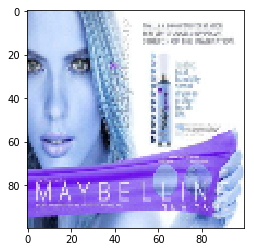

Layer: Text


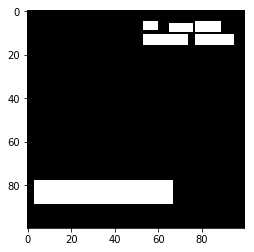

Layer: {'Person', 'Girl', 'Human body', 'Boy', 'Man', 'Woman'}


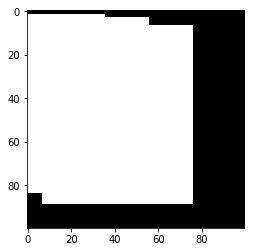

Layer: {'Face', 'Mouth', 'Hair', 'Beard', 'Arm', 'Head', 'Eye', 'Ear', 'Nose', 'Hand', 'Leg'}


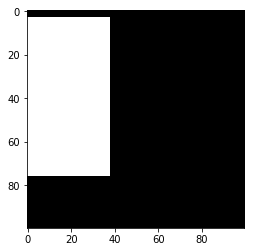

In [10]:
%matplotlib inline
img_mask = image_manager.files[5].reshape([100, 100, NUM_BYTES_FOR_MASK])
folder_path = os.path.join(image_manager.folder_path, '0')
img = cv2.imread(os.path.join(folder_path, os.listdir(folder_path)[5]))
img = cv2.resize(img, (100,100))

plt.figure()
plt.imshow(img)
plt.show()

plt.figure()
print('Layer: Text')
plt.imshow(img_mask[:,:,0], origin="upper", cmap="gray")
plt.show()
        
for i in range(1,NUM_BYTES_FOR_MASK):
    if np.count_nonzero(img_mask[:,:,i])>0:
        print('Layer:',clustered_classes[i-1])
        fig = plt.figure()
        plt.imshow(img_mask[:,:,i], origin="upper", cmap="gray")
        plt.show()

# BETA VARIATIONAL AUTOENCODER

In [53]:
# Parameters

tf.reset_default_graph()

learning_rate = 1e-4
num_steps = 20
batch_size = 16
# Network Parameters
NUM_BYTES_FOR_MASK = 3+1
image_dim = 100*100*NUM_BYTES_FOR_MASK # images are 100x100 pixels
hidden_dim1 = 1024
hidden_dim2 = 128
latent_dim = 40
n_samples = image_manager.files.shape[0]
beta = 0.3
# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

In [54]:
MODEL_PATH = os.path.join(OUT_TF_DATA,'models')+'/'+'_'.join(['vae',str(hidden_dim1),str(hidden_dim2),str(latent_dim),'sigmoid','adam'])

In [214]:
# Variables
weights = {
    'encoder_h1': tf.Variable(glorot_init([image_dim, hidden_dim1])),
    'encoder_h2': tf.Variable(glorot_init([hidden_dim1, hidden_dim2])),
    'z_mean': tf.Variable(glorot_init([hidden_dim2, latent_dim])),
    'z_std': tf.Variable(glorot_init([hidden_dim2, latent_dim])),
    'decoder_h1': tf.Variable(glorot_init([latent_dim, hidden_dim2])),
    'decoder_h2': tf.Variable(glorot_init([hidden_dim2, hidden_dim1])),
    'decoder_out': tf.Variable(glorot_init([hidden_dim1, image_dim]))
}
biases = {
    'encoder_b1': tf.Variable(glorot_init([hidden_dim1])),
    'encoder_b2': tf.Variable(glorot_init([hidden_dim2])),
    'z_mean': tf.Variable(glorot_init([latent_dim])),
    'z_std': tf.Variable(glorot_init([latent_dim])),
    'decoder_b1': tf.Variable(glorot_init([hidden_dim2])),
    'decoder_b2': tf.Variable(glorot_init([hidden_dim1])),
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}

In [215]:
# Building the encoder
input_image = tf.placeholder(tf.float32, shape=[None, image_dim], name='input')
encoder1 = tf.matmul(input_image, weights['encoder_h1']) + biases['encoder_b1']
encoder1 = tf.nn.leaky_relu(encoder1)
# encoder1 = tf.nn.dropout(encoder1, 0.5)
encoder2 = tf.matmul(encoder1, weights['encoder_h2']) + biases['encoder_b2']
encoder = tf.nn.leaky_relu(encoder2, name='encoder')
# encoder2 = tf.nn.dropout(encoder, 0.5)
z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std']

# Sampler: Normal (gaussian) random distribution
eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0,
                       name='epsilon')
z = tf.add(z_mean, tf.exp(z_std / 2) * eps, name='hidden')


# Building the decoder (with scope to re-use these layers later)
decoder1 = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
decoder1 = tf.nn.leaky_relu(decoder1)
# decoder1 = tf.nn.dropout(decoder1, 0.5)
decoder2 = tf.matmul(decoder1, weights['decoder_h2']) + biases['decoder_b2']
decoder2 = tf.nn.leaky_relu(decoder2)
# decoder2 = tf.nn.dropout(decoder2, 0.5)
decoder = tf.matmul(decoder2, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder, name='decoder')

In [216]:
# Define VAE Loss
def vae_loss(x_reconstructed, x_true):
    # Reconstruction loss
#     x_reconstructed = tf.clip_by_value(x_reconstructed, 1e-7, 1 - 1e-7)
    encode_decode_loss = x_true * tf.log(1e-7 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-7 + 1 - x_reconstructed)
    
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    # KL Divergence loss
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -beta * 0.5 * tf.reduce_sum(kl_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)

loss_op = vae_loss(decoder, input_image)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)


# TEST GENERATED IMAGES

In [217]:
def image_test_and_plot(image_manager, sess):
#     %matplotlib inline
    dim_ = 100
    n = 4
    canvas_orig = np.empty((dim_ * n, dim_ * n, NUM_BYTES_FOR_MASK))
    canvas_recon = np.empty((dim_ * n, dim_ * n, NUM_BYTES_FOR_MASK))
    for i in range(n):
        # Image test set
        batch_x = image_manager.next_batch(n)
        batch_x = batch_x[:, :, :, :NUM_BYTES_FOR_MASK]
        batch_x = batch_x.reshape(batch_x.shape[0], -1).astype(np.float16)
        # Encode and decode the digit image
        output = tf.get_default_graph().get_tensor_by_name("decoder:0")
        ip_img= tf.get_default_graph().get_tensor_by_name("input:0")
        g = output.eval(feed_dict={ip_img: batch_x})
#         print(g)
        # Display original images
        for j in range(n):
    #         print (batch_x[j])
            # Draw the generated digits
            canvas_orig[i * dim_:(i + 1) * dim_, j * dim_:
                        (j + 1) * dim_,:] = batch_x[j].reshape([dim_, dim_, NUM_BYTES_FOR_MASK])

    #     print (np.max(g[0]))
        # Display reconstructed images
        for j in range(n):
            # Draw the generated digits
            canvas_recon[i * dim_:(i + 1) * dim_, j * dim_:
                         (j + 1) * dim_,:] = g[j].reshape([dim_, dim_, NUM_BYTES_FOR_MASK])
    print(np.linalg.norm(canvas_orig - canvas_recon)/n)

    
    print("Original Images vs Reconstructed Images")  
    for i in range(NUM_BYTES_FOR_MASK):
        print('Layer:',i)
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(canvas_orig[:,:,i], origin="upper", cmap="gray")
        axarr[1].imshow(canvas_recon[:,:,i], origin="upper", cmap="gray")
        plt.show()
    


# RUN MODEL

# SET GPU List

In [218]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

<IPython.core.display.Javascript object>


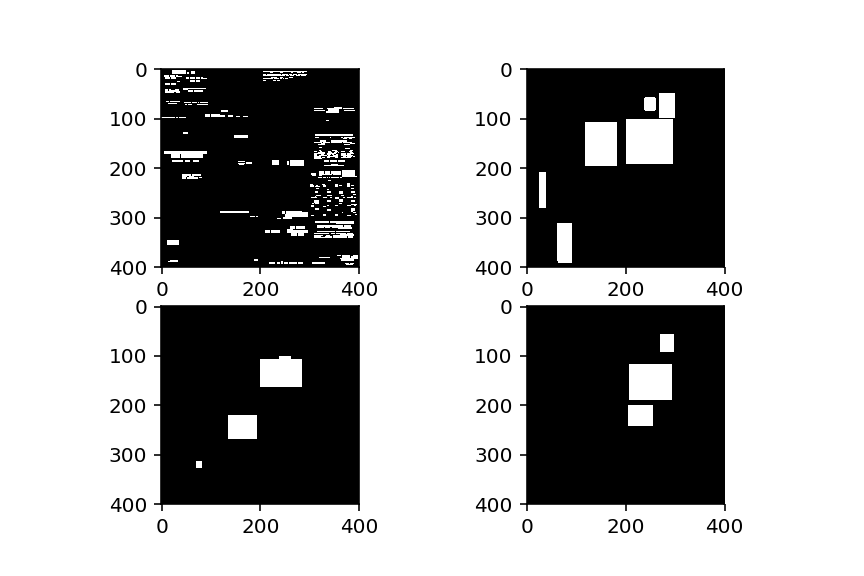

In [219]:
# %matplotlib inline
import math
test_images = test_image_manager.next_batch(16)[:, :, :, :NUM_BYTES_FOR_MASK]
test_images = test_images.reshape(test_images.shape[0], -1).astype(np.float16)
canvas_recon = np.zeros((100 * 4, 100 * 4, NUM_BYTES_FOR_MASK))
for j in range(16):
    # Draw the generated digits 
    x = j//4
    y = j%4
#         print(test_images[j].reshape([100, 100, NUM_BYTES_FOR_MASK]).shape)
#         print(test_images[j].shape)
    canvas_recon[y * 100:(y + 1) * 100, x * 100:
                 (x + 1) * 100,:] = test_images[j].reshape([100, 100, NUM_BYTES_FOR_MASK])
f, axarr = plt.subplots(2,2)

for i in range(NUM_BYTES_FOR_MASK):
    axarr[i//2][i%2].imshow(canvas_recon[:,:,i], origin="upper", cmap="gray")
# plt.show()
# plt.tight_layout()

<IPython.core.display.Javascript object>


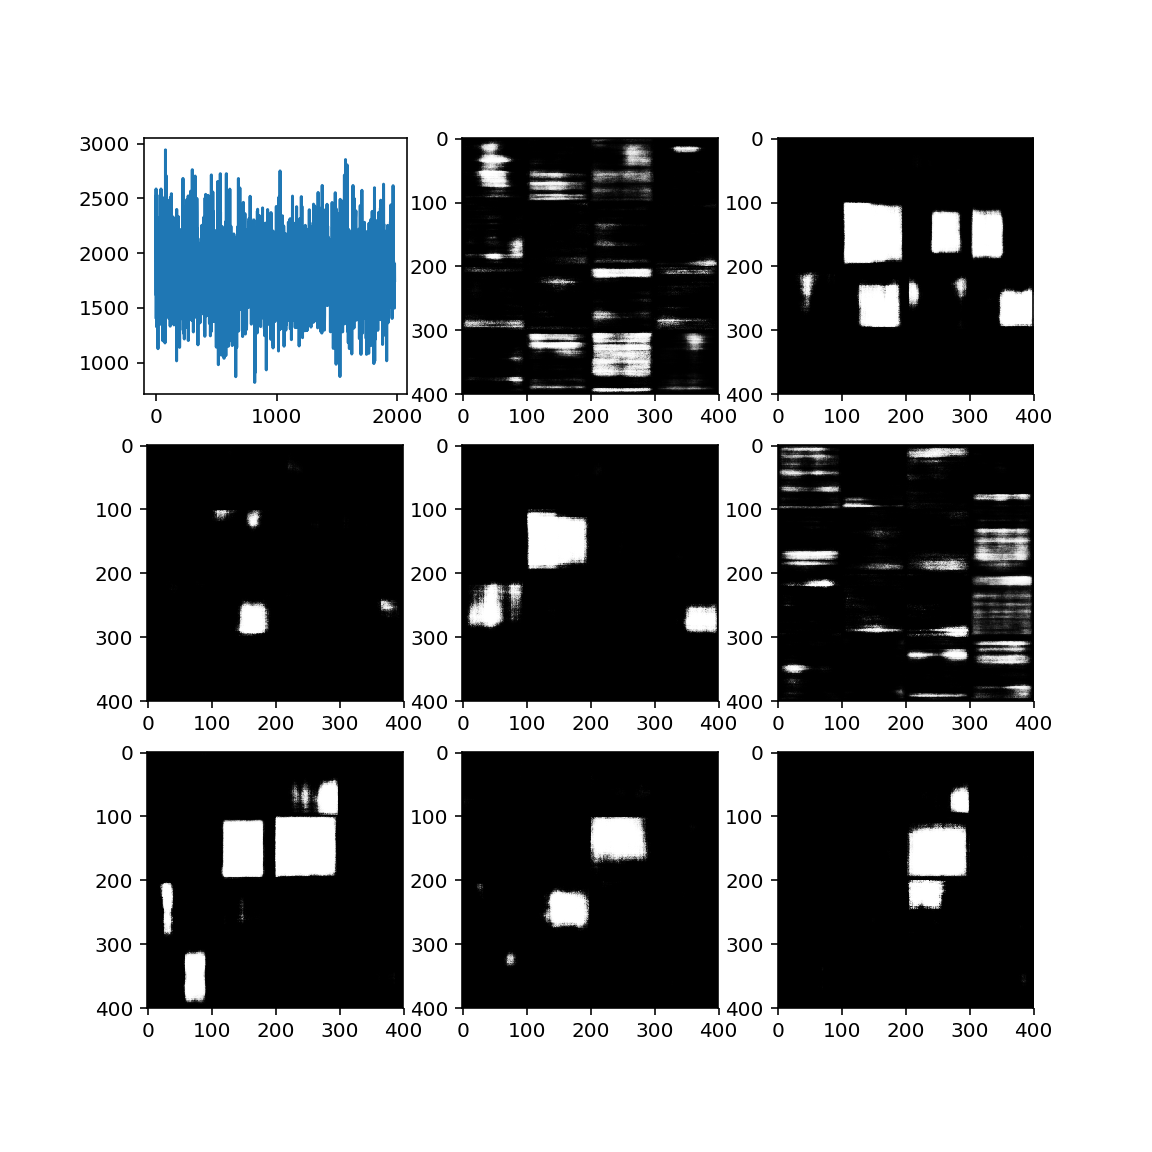

A Jupyter Widget



Saved model at: /gpfs/scratch/asamanta/models/vae_1024_128_40_sigmoid_adam/model.ckpt
22.390386018
Original Images vs Reconstructed Images
Layer: 0


<IPython.core.display.Javascript object>


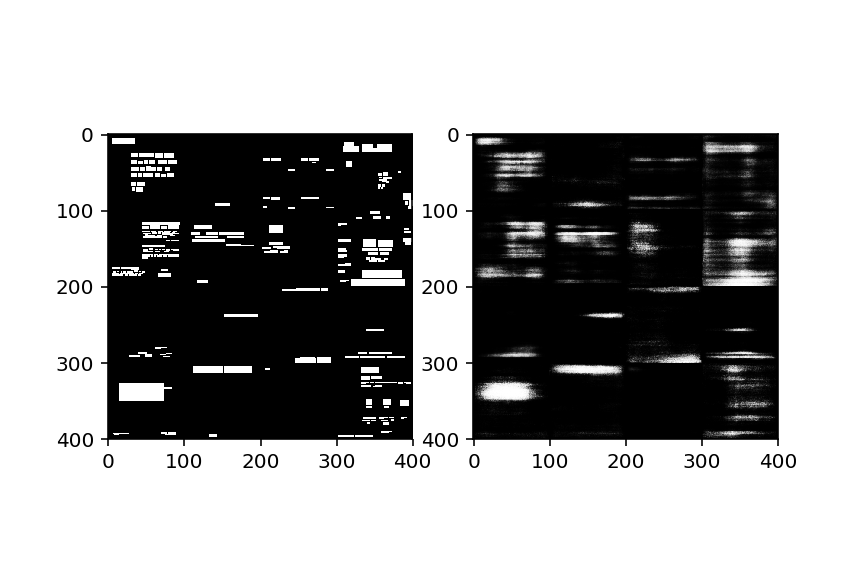

Layer: 1


<IPython.core.display.Javascript object>


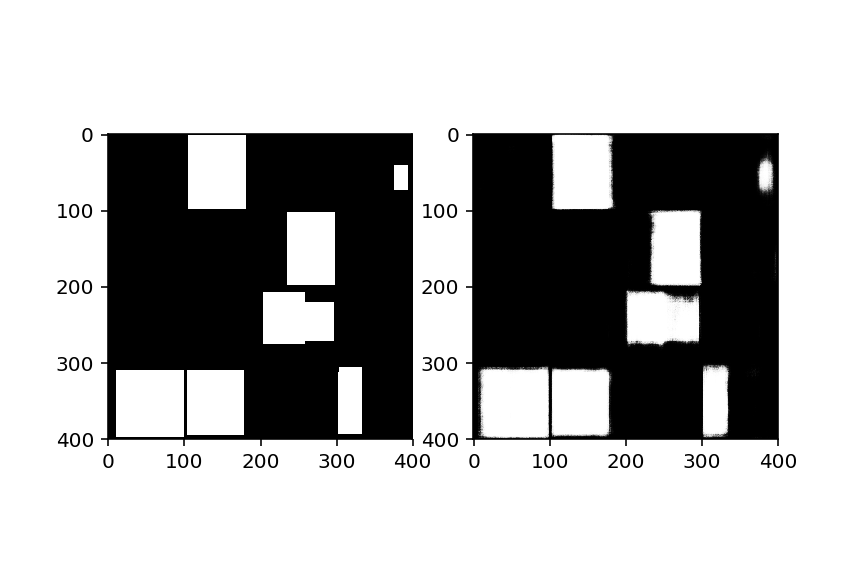

Layer: 2


<IPython.core.display.Javascript object>


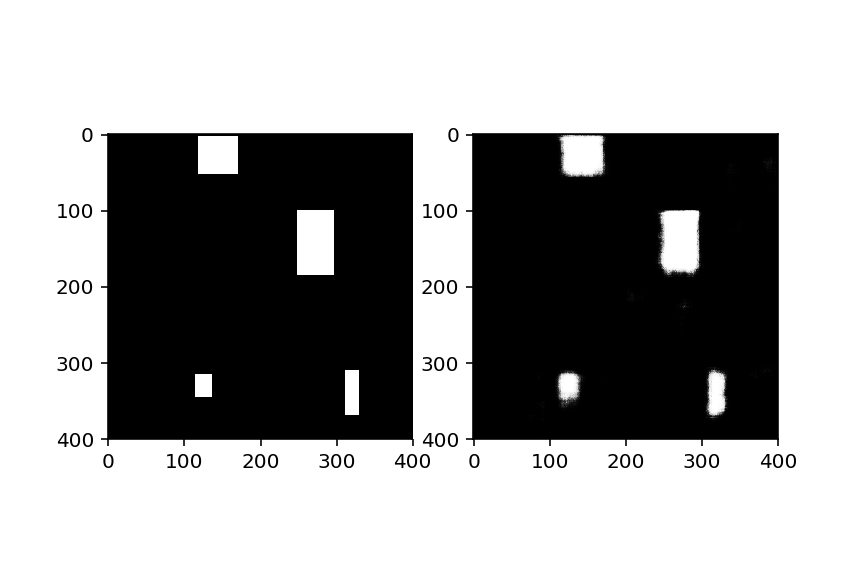

Layer: 3


<IPython.core.display.Javascript object>


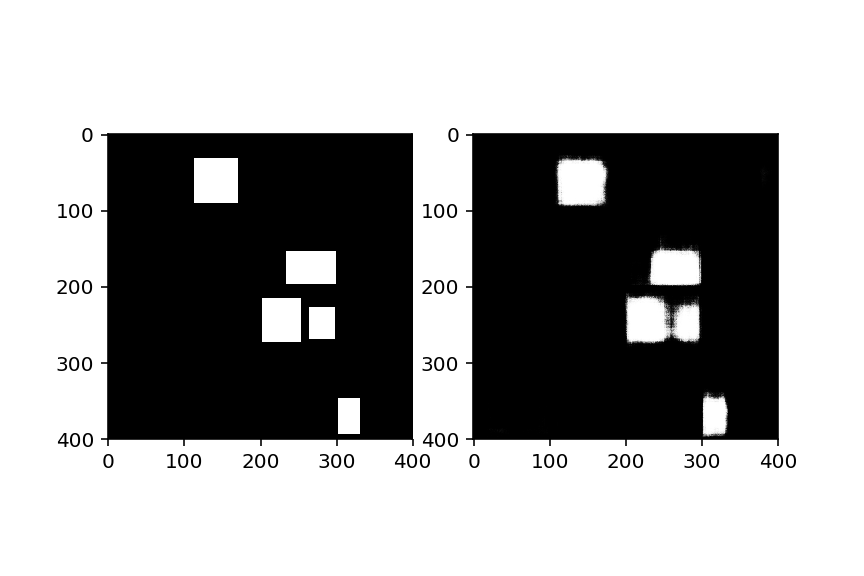

[3120.8086, 2706.6235, 2500.2993, 2410.6282, 2311.5818, 2189.9438, 2250.6016, 2134.8989, 2058.7566, 2026.9329, 2031.6393, 2056.1396, 1986.5891, 1931.712, 2001.957, 1992.1526, 1942.1746, 1961.6749, 1906.2344, 1968.1123]


<IPython.core.display.Javascript object>


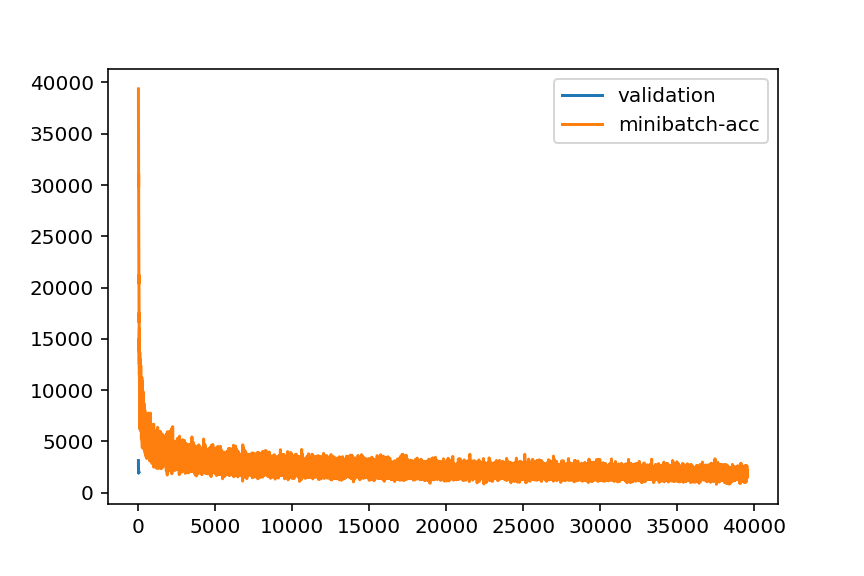

CPU times: user 26min 30s, sys: 3min 30s, total: 30min
Wall time: 33min 26s


In [220]:
%%time
%matplotlib notebook
# Start Training
# Start a new TF session
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()
batch_loss_plot = []
test_loss_plot = []

with tf.Session() as sess:
    # Run the initializer
    sess.run(init)
    
    saver = tf.train.Saver()

    fig,ax = plt.subplots(3,3,figsize=(8,8))
#     plt.ion()
    
    for k in range(NUM_BYTES_FOR_MASK):
        ax[(k+5)//3][(k+5)%3].clear()
        ax[(k+5)//3][(k+5)%3].imshow(canvas_recon[:,:,k], origin="upper", cmap="gray")
    
#     fig.show()
    fig.canvas.draw()
    # Training
    try:
        for i in tqdm_notebook(range(num_steps)):
            # Prepare Data
            # Get the next batch of MNIST data (only images are needed, not labels)
            avg_loss = 0.
            total_batch = n_samples // batch_size
    #         total_batch = 2000

            # Loop over all batches
            for j in range(total_batch):
                batch_x = image_manager.next_batch(batch_size)
                batch_x = batch_x[:, :, :, :NUM_BYTES_FOR_MASK]
                batch_x = batch_x.reshape(batch_x.shape[0], -1).astype(np.float16)
                # Train
                feed_dict = {input_image: batch_x}
                _, l = sess.run([train_op, loss_op], feed_dict=feed_dict)
                avg_loss += l / n_samples * batch_size
                batch_loss_plot.append(l)
                if (j%(total_batch//10))==0:
                    ax[0][0].clear()
                    ax[0][0].plot(batch_loss_plot[-total_batch:])
                    g = decoder.eval(feed_dict={input_image: batch_x})
                    for k in range(16):
                        # Draw the generated digits 
                        x = k//4
                        y = k%4
                        canvas_recon[y * 100:(y + 1) * 100, x * 100:
                                     (x + 1) * 100,:] = g[k].reshape([100, 100, NUM_BYTES_FOR_MASK])
                    for k in range(4):
                        ax[(k+1)//3][(k+1)%3].clear()
                        ax[(k+1)//3][(k+1)%3].imshow(canvas_recon[:,:,k], origin="upper", cmap="gray")
                    fig.canvas.draw()

            validation_error = loss_op.eval(feed_dict={input_image: test_images})

            g = decoder.eval(feed_dict={input_image: test_images})
            for j in range(16):
                # Draw the generated digits 
                x = j//4
                y = j%4
                canvas_recon[y * 100:(y + 1) * 100, x * 100:
                             (x + 1) * 100,:] = g[j].reshape([100, 100, NUM_BYTES_FOR_MASK])
            for k in range(NUM_BYTES_FOR_MASK):
                ax[(k+5)//3][(k+5)%3].clear()
                ax[(k+5)//3][(k+5)%3].imshow(canvas_recon[:,:,k], origin="upper", cmap="gray")
                fig.canvas.draw()

            test_loss_plot.append(validation_error)
    except KeyboardInterrupt:
        print('Stopped')
    model_name = MODEL_PATH +'/model.ckpt'
    save_path = saver.save(sess, model_name)
    
    export_dir = MODEL_PATH
    inputs = {'input': input_image}
    hidden = {'hidden': encoder}
    outputs = {'output': decoder}
    print('Saved model at:', save_path)

    image_test_and_plot(image_manager, sess)
    print(test_loss_plot)
    
    p = plt.figure()
    plt.plot(test_loss_plot, label='validation')
    plt.plot(batch_loss_plot, label='minibatch-acc')
    plt.legend()
    plt.show()

## Restore session from saved model

INFO:tensorflow:Restoring parameters from /gpfs/scratch/asamanta/models/vae_1024_128_40_sigmoid_adam/model.ckpt
25.7487768667
Original Images vs Reconstructed Images
Layer: 0


<IPython.core.display.Javascript object>


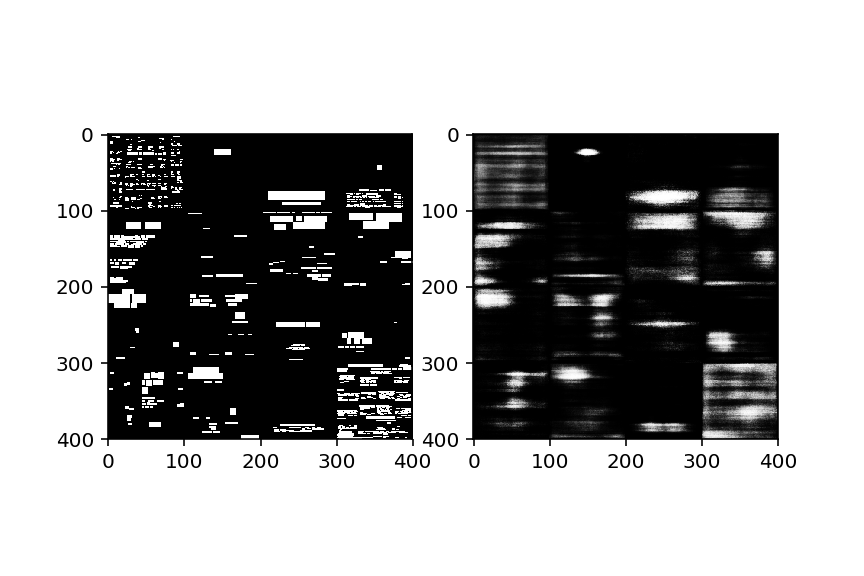

Layer: 1


<IPython.core.display.Javascript object>


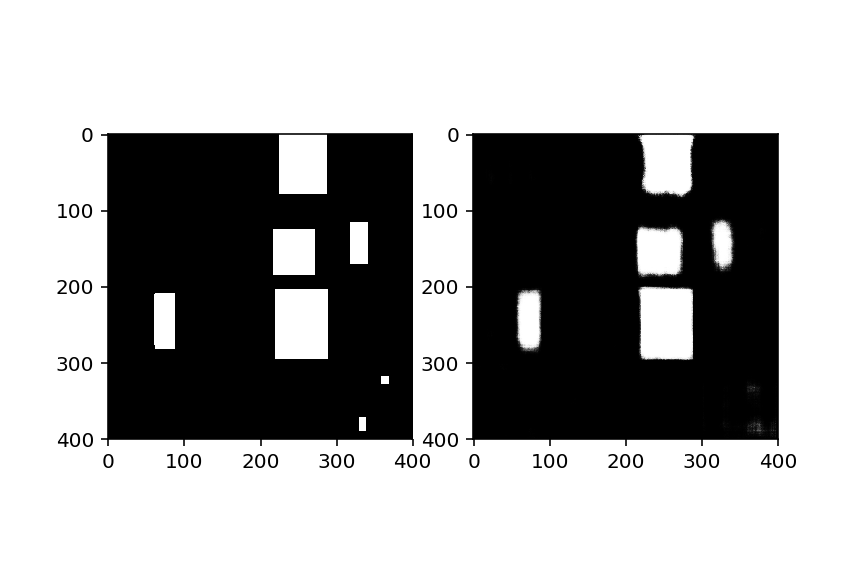

Layer: 2


<IPython.core.display.Javascript object>


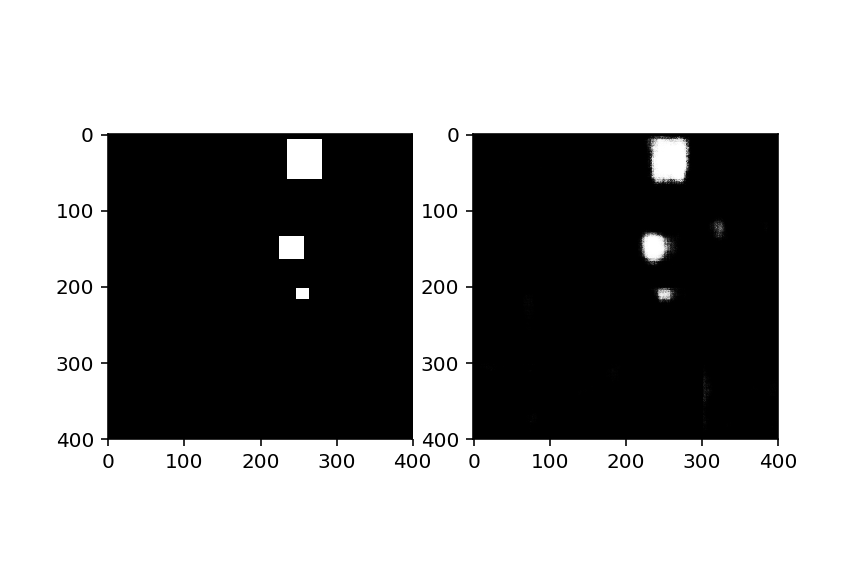

Layer: 3


<IPython.core.display.Javascript object>


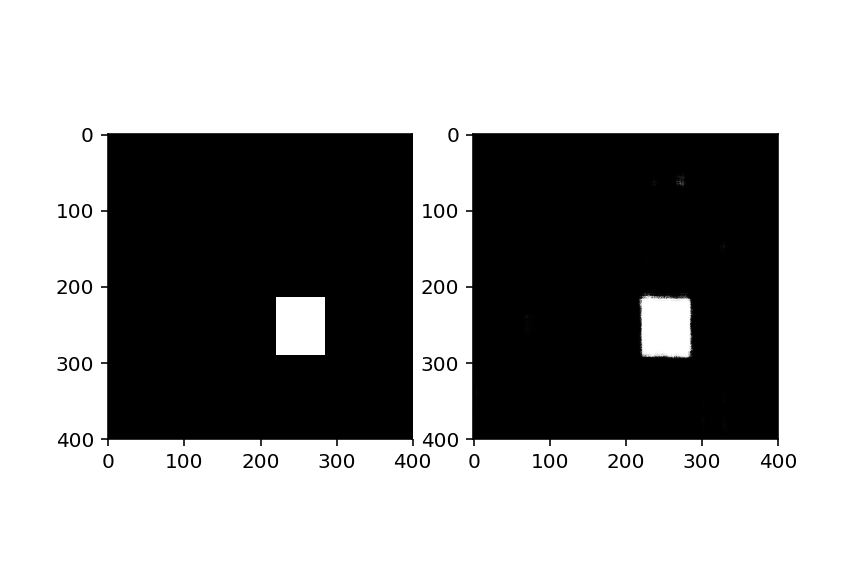

In [221]:
# MODEL_PATH = '/gpfs/scratch/asamanta/models/vae_1024_128_32_sigmoid_adam'
tf.reset_default_graph()
with tf.Session() as sess:
  # Initialize v1 since the saver will not.
#   v1.initializer.run()
    saver = tf.train.import_meta_graph(MODEL_PATH+'/model.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint(MODEL_PATH))
    image_test_and_plot(test_image_manager, sess)

# GENERATING Designs

<IPython.core.display.Javascript object>


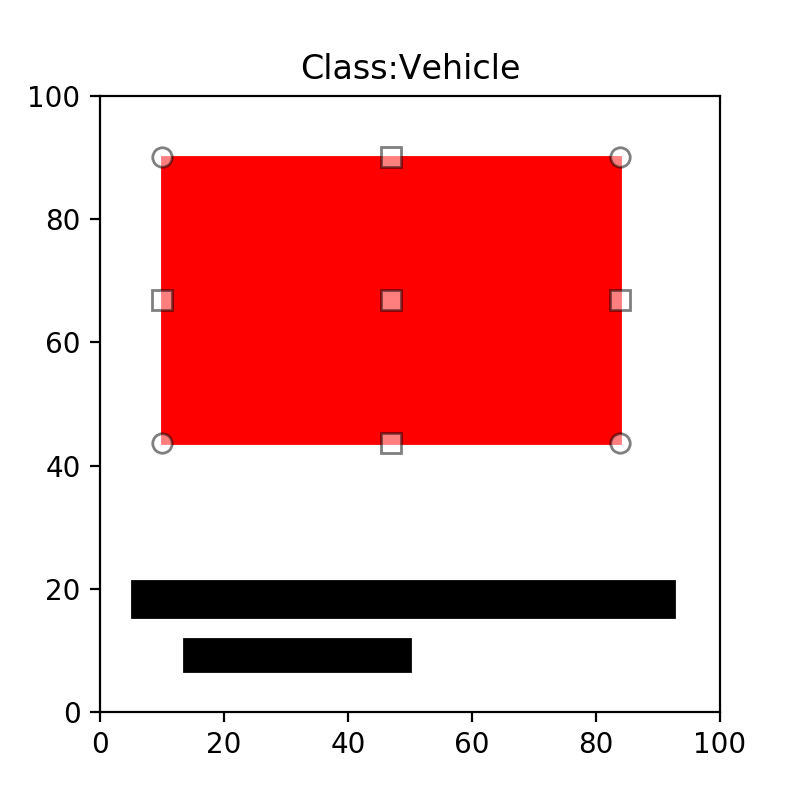

In [66]:
from matplotlib.widgets  import RectangleSelector
rect_colors = {'2':'#00FF00', '3':'#0000ff', '4':'#ff0000', '1': '#000000'}
color_tuples = {'2':[0,255,0], '3':[0,0,255], '4':[255,0,0], '1': [0,0,0]}
layers = {'2':2, '3':1, '4':3, '1':0}
layer_names = {'2':'Human', '3':'Body part', '4':'Vehicle', '1':'Text'}

%matplotlib notebook
xdata = np.linspace(0,100, num=100)
ydata = np.linspace(0,100, num=100)

fig, ax = plt.subplots(figsize=(4,4))
ax.set_ylim(0,100)
ax.set_xlim(0,100)
# line, = ax.plot(xdata, ydata)
event_list = []
key_list = []

def toggle_selector(event):
    print(' Key pressed.')
    if event.key in ['Q', 'q'] and toggle_selector.RS.active:
        print(' RectangleSelector deactivated.')
        toggle_selector.RS.set_active(False)
    if event.key in ['R', 'r']:
        print(' RectangleSelector reset.')
        ax.cla()
        ax.set_ylim(0,100)
        ax.set_xlim(0,100)
    if event.key in rect_colors.keys():
        ax.set_title('Class:'+layer_names[event.key])
        print('Class', event.key)
        key_list.append(event.key)
        

def line_select_callback(eclick, erelease):
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    try:
        color = rect_colors[key_list[-1]]
    except:
        color = rect_colors['1']
    rect = plt.Rectangle((min(x1,x2),min(y1,y2)), np.abs(x1-x2), np.abs(y1-y2), color=color)
    event_list.append((key_list[-1], int(min(x1,x2)),int(min(y1,y2)), int(np.abs(x1-x2)), int(np.abs(y1-y2))))
    ax.add_patch(rect)


rs = RectangleSelector(ax, line_select_callback,
                       drawtype='box', useblit=True, button=[1], 
                       minspanx=5, minspany=5, spancoords='pixels', 
                       interactive=True)
plt.connect('key_press_event', toggle_selector)
plt.show()

In [44]:
from ipywidgets import *
from IPython.display import display
from IPython.html import widgets

INFO:tensorflow:Restoring parameters from /gpfs/scratch/asamanta/models/vae_1024_128_40_sigmoid_adam/model.ckpt


<IPython.core.display.Javascript object>


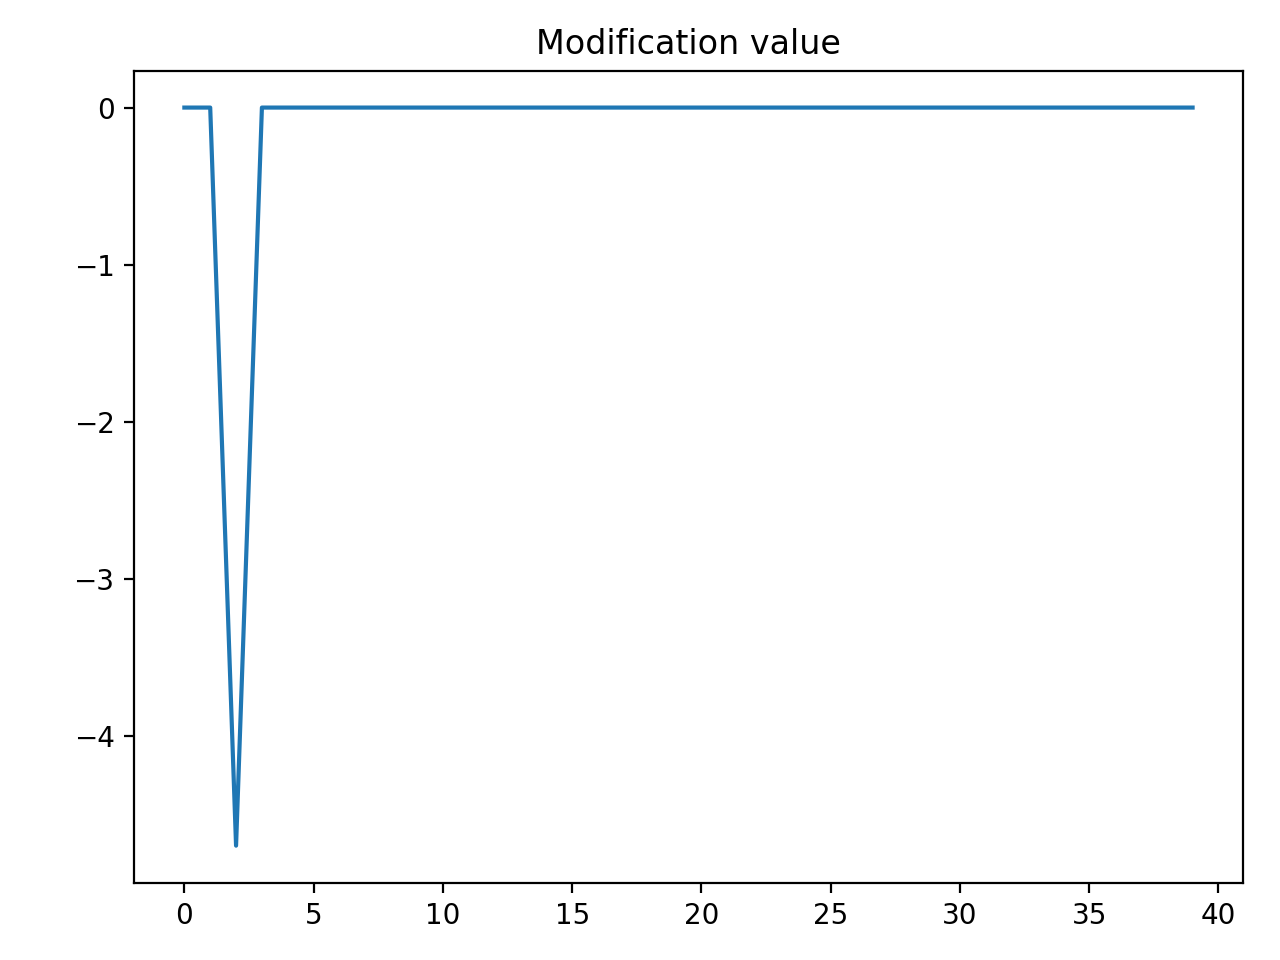

A Jupyter Widget

24.5764114549


A Jupyter Widget

<IPython.core.display.Javascript object>


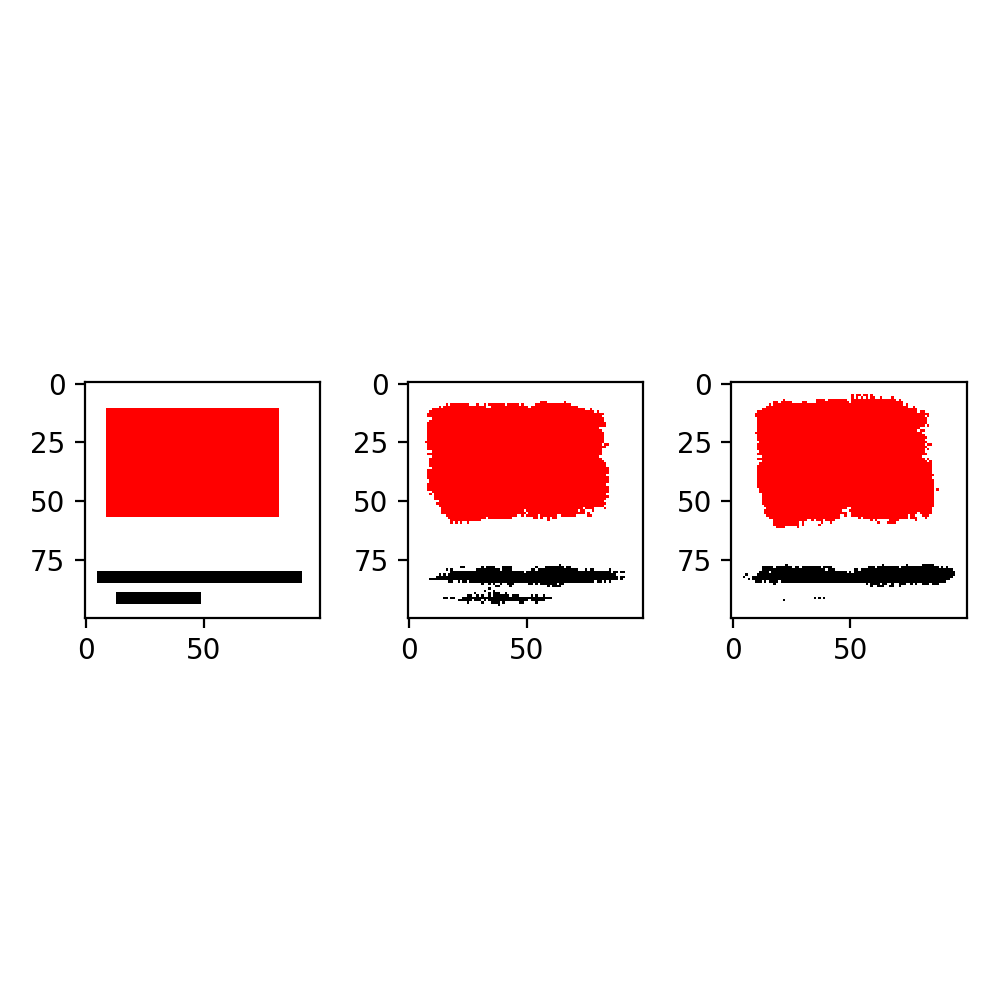

Original Images vs Reconstructed Images


In [67]:

test_image = np.zeros((1,100,100,NUM_BYTES_FOR_MASK), dtype=np.uint8)
for key, x, y, dx, dy in event_list:
    test_image[0, 100-y-dy:100-y, x:x+dx,layers[key]] = 1

img_mask = test_image[0]

# MODEL_PATH = '/gpfs/scratch/asamanta/models/vae_1024_256_64_sigmoid_adam/'
tf.reset_default_graph()
sess = tf.Session()
  # Initialize v1 since the saver will not.
#   v1.initializer.run()
saver = tf.train.import_meta_graph(MODEL_PATH+'/model.ckpt.meta')
saver.restore(sess, tf.train.latest_checkpoint(MODEL_PATH))
dim_ = 100

# Image test set
batch_x = test_image
batch_x = batch_x.reshape(batch_x.shape[0], -1).astype(np.float32)

orig_img = np.ones(shape=(100,100,3), dtype=np.uint8)*255
recons_img = np.ones(shape=(100,100,3), dtype=np.uint8)*255
mod_img = np.ones(shape=(100,100,3), dtype=np.uint8)*255

# Encode and decode the digit image
output = tf.get_default_graph().get_tensor_by_name("decoder:0")
ip_img = tf.get_default_graph().get_tensor_by_name("input:0")
hidden =  tf.get_default_graph().get_tensor_by_name("hidden:0")
encoded_output = hidden.eval(feed_dict={ip_img: batch_x},session=sess)
g = output.eval(feed_dict={hidden: encoded_output},session=sess)

mod_value_list = np.zeros((latent_dim), dtype=np.float32)
fig = plt.figure()

ax = fig.add_subplot(111)
ax.plot(mod_value_list)
ax.set_ylim(-10,10)


mod_dim = 0
def change_dim(input_dim=0):
    global mod_dim
    mod_dim = input_dim

interact(change_dim, input_dim=widgets.IntSlider(min=0,max=latent_dim,step=1,value=0))



canvas_orig = np.round(batch_x).astype(int).reshape([dim_, dim_, NUM_BYTES_FOR_MASK])
canvas_recon = np.round(g).astype(int).reshape([dim_, dim_, NUM_BYTES_FOR_MASK])
canvas_mod = np.round(g).astype(int).reshape([dim_, dim_, NUM_BYTES_FOR_MASK])
print(np.linalg.norm(canvas_orig - canvas_recon))
# fig.show()
def create_new_image(mod_value):
    global mod_dim, mod_value_list
    mod_value_list[mod_dim] = mod_value
    temp_encoded_output = encoded_output.copy()
    temp_encoded_output[0][mod_dim] += mod_value_list[mod_dim]
    ax.clear()
    ax.plot(mod_value_list)
    ax.set_title('Modification value')
    mod_g = output.eval(feed_dict={hidden: temp_encoded_output}, session=sess)
    canvas_mod = np.round(mod_g).astype(int).reshape([dim_, dim_, NUM_BYTES_FOR_MASK])
    mod_img[:,:,:] = 255
    for i in range(NUM_BYTES_FOR_MASK):
        mod_img[(canvas_mod[:,:,i]==1)] = color_tuples[str(i+1)]
        axarr[2].clear()
        axarr[2].imshow(mod_img)
    plt.tight_layout()
    plt.show()
interact(create_new_image, mod_value=widgets.FloatSlider(min=-10.0,max=10.0,step=0.1,value=0.0))

f, axarr = plt.subplots(1,3, figsize=(5,5))
print("Original Images vs Reconstructed Images")  
for i in range(NUM_BYTES_FOR_MASK):
    orig_img[(canvas_orig[:,:,i]==1)] = color_tuples[str(i+1)]
    mod_img[(canvas_recon[:,:,i]==1)] = color_tuples[str(i+1)]
    recons_img[(canvas_mod[:,:,i]==1)] = color_tuples[str(i+1)]
axarr[0].imshow(orig_img)
axarr[1].imshow(recons_img)
axarr[2].imshow(mod_img) 
plt.tight_layout()

In [276]:
sess.close()